# A/B–тестирование
Одной из основных задач аналитика является корректное проведение экспериментов. Для этого обычно применяется метод A/B–тестирования.

В данном проекте, входе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Задача: проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# Импорт библиотек
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Задаем вид графиков
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# Загрузка данных
groups       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep=';')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
checks       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep=';')

* groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

## Шаг 1. Изучение данных

In [11]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [12]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [13]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [14]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


**Кол-во строк во всех проверяемых таблицах соответствует кол-ву значений по колонке id, - это значит что все значения таблиц уникальны**



## Шаг 2. Объединение таблиц
Для начала нам необходимо объединить информацию из разных таблиц. 

Файл active_studs содержит инфоомацию об id пользователей, которые зашли на платформу в дни проведения эксперимента, в то время как groups - группы, к которым принадлежат эти пользователи. Таблица checks содержит информацию о выручке с пользователя. Создадим новую таблицу, где будет содержаться id пользователя, его группа и чек.

Для этого сначала необходимо переименовать столбец "id" таблицы groups в "student_id" для объединения.

In [10]:
groups.rename(columns={'id': 'student_id'}, inplace=True)

In [11]:
# Объединяем таблицы в единый df и очищаем от NaN, если student_id не попал нив одну группу
df = active_studs.merge(groups, on='student_id', how='left').dropna()
df = df.merge(checks, on='student_id', how='left')
df

,student_id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN
...,...,...,...
8323,1794344,B,NaN
8324,296883,B,NaN
8325,3598448,B,NaN
8326,3610547,B,290.0


## Шаг 3. Разделение на группы
Следующим шагом разделим нашу таблицу на две - разнесем пользователей по группам.

In [12]:
group_a = df.query('grp == "A"')
print('Количество пользователей в контрольной группе:', len(group_a))
group_b = df.query('grp == "B"')
print('Количество пользователей в целевой группе:', len(group_b))

Количество пользователей в контрольной группе: 1535
Количество пользователей в целевой группе: 6793


Как мы видим, в группах присутствует не равное количество пользователей.


## Шаг 4. Сравниваем ключевые метрики
Наша ключевая метрика - выручка. Однако так как в наших группах разное количество пользователей, нам также интересно узнать, как изменилась выручка на пользователя (ARPU - average revenue per user).

Посмотрим на основные статистические характеристики метрик по обеим группам, далее посмотрим на их распределения

In [13]:
# Для начала ARPU в обеих группах 
ARPU_a = (group_a.rev.sum() / len(group_a)).round(2)
ARPU_b = (group_b.rev.sum() / len(group_b)).round(2)
print('ARPU в контрольной группе составляет', ARPU_a)
print('ARPU в целевой группе составляет', ARPU_b)
print('\nВ целевой группе эта метрика на', str((ARPU_b*100/ARPU_a - 100).round(2)) + '% больше, чем в контрольной')

ARPU в контрольной группе составляет 47.44
ARPU в целевой группе составляет 57.86

В целевой группе эта метрика на 21.96% больше, чем в контрольной


In [14]:
# Теперь посмотрим на средние значения выручки в обеих группах 
print('Средняя выручка в контрольной группе составляет', group_a.rev.mean().round(2))
print('Средняя выручка в целевой группе составляет', group_b.rev.mean().round(2))

Средняя выручка в контрольной группе составляет 933.59
Средняя выручка в целевой группе составляет 1255.83


In [15]:
# сравним с медианным значением выручки
print('Медианная выручка в контрольной группе составляет', group_a.rev.median())
print('Медианная выручка в целевой группе составляет', group_b.rev.median())

Медианная выручка в контрольной группе составляет 585.0
Медианная выручка в целевой группе составляет 1140.0


In [16]:
# теперь посмотрим на средние отклонения значений в группах
print('Стандартное отклонение в контрольной группе составляет', group_a.rev.std().round(2))
print('Стандартное отклонение в целевой группе составляет', group_b.rev.std().round(2))

Стандартное отклонение в контрольной группе составляет 919.93
Стандартное отклонение в целевой группе составляет 791.29


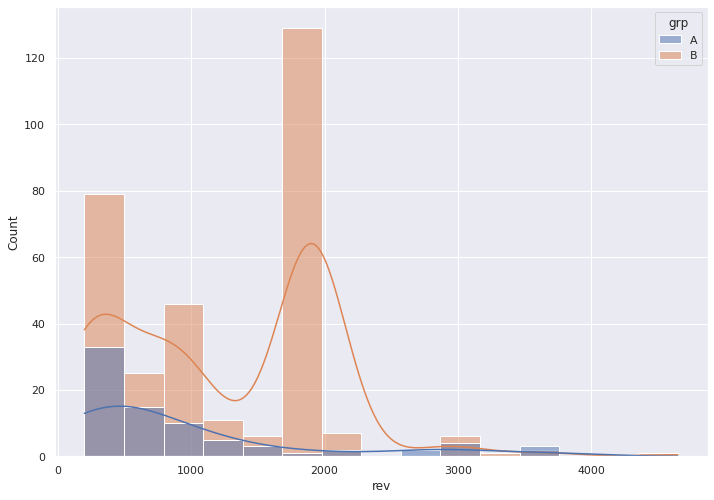

In [17]:
# Посмотрим на распределения выручки по нашим группам
sns.histplot(data=df, x='rev', hue='grp', kde=True, bins=15)

На первый взгляд кажется, будто выручка у целевой группе в большинстве случаев существенно выше, чем в контрольной, теперь выясним, действительно ли данные отличаются статистически значимо.



## Шаг 5. Определяем нулевую гипотезу и применяем статистические тесты
**Нулевая гипотеза - данные не отличаются друг от друга**

Нулевую гипотезу принимaют, если наше значение p выше заданного уровня значимости. Мы будем считать различия значимыми при pvalue больше 0,05. 
### t-test

In [18]:
# t-test
group_a_without_na = group_a.dropna()
group_b_without_na = group_b.dropna()
stats.ttest_ind(group_a_without_na.rev, group_b_without_na.rev)

Ttest_indResult(statistic=-3.1114389810411063, pvalue=0.001999178025210522)

В нашем случае значение существенно меньше 0,05, то есть теоретически мы можем принять альтернативную гипотезу о том, что выручки в группах А и В отличаются друг от друга.

Однако, как мы можем видеть на графиках, распределения ассиметричны и количество значений в группах не равны, поэтому результаты т-теста могут давать неверные результаты, поэтому посмотрим, какое значение нам покажет непараметрический U-критерий Манна-Уитни.

### U-тест Манна-Уитни

In [19]:
# u-test
stats.mannwhitneyu(group_a_without_na.rev, group_b_without_na.rev)

MannwhitneyuResult(statistic=8990.0, pvalue=0.000273244700505943)

U-критерий Манна-Уитни не требует симметричности распределения, поэтому в нашем случае, возможно, этот критерий более предпочтителен. Однако стоит учитывать то, что этот критерий показывает, насколько отличаются средние *ранги* в наших группах. То есть p-value=0.00027 говорит нам о том, что различия *рангов выручки* в контрольной и целевой группах статистически значимо отличаются, но о разнице средних и медиан что-либо сказать сложно. 

Однако стоит отметить, что уже два метода привели к одному результату - мы можем отклонить нулевую гипотезу и принять альтернативную.

Проверим нашу гипотезу еще одним распространенным методом - бутстрап.

### bootstrap

In [20]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [21]:
x = group_a_without_na.rev
y = group_b_without_na.rev

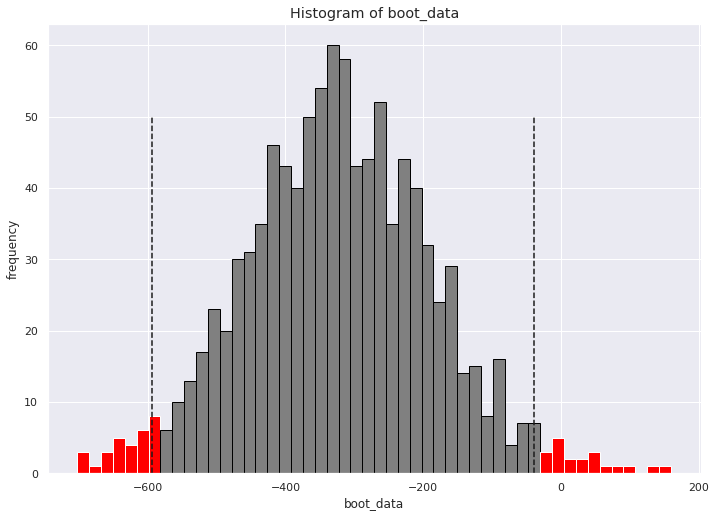

In [22]:
booted_data = get_bootstrap(x, y) # в результате хранится разница двух распределений, ДИ и pvalue

In [23]:
booted_data["p_value"] # альфа

0.017004990314234362

In [24]:
booted_data["quants"] # Доверительный интервал

,0
0.025,-592.932063
0.975,-38.920846


## Шаг 6. Делаем вывод
В нашем случае, бутстрап считает разницу между медианами бутстрапированных выборок. Если бы разница между проверяемыми значениями отсутствовала, то разность между медианами была бы равной нулю (попала в интервал, который включает в себя 0). Однако наш результат не включает ноль. 95% доверительный интервал лежит в промежутке ~от -586 до -52.

Следовательно:
* выручка в контрольной и целевой группах стат-значимо **отличается**;
* медианная выручка в целевой группе практически **в 2 раза превышает** медианную выручку в контрольной группе;
* рекомендуется **запускать новую механику** на всех пользователей.

|

|

# Новые данные

Случается, что аналитику присылают дополнительную информацию по исследуемым группам. В нашем случае, добавился файл 'groups_add.csv', который содержит информацию о пользователях, которые также принимали участие в эксперименте.

Реализуем функцию, которая будет автоматически подгружать информацию и строить графики из дополнительного файла и на основании дополнительных параметров пересчитывать метрики

In [3]:
def check_p(pvalue):
    if pvalue > 0.05:
        return 'Принимаем нулевую гипотезу - выручки групп статистически значимо не отличаются друг от друга'
    else:
        return 'Отклоняем нулевую гипотезу - выручки групп статистически значимо отличаются друг от друга'
    

def summary(pvalue):
    if pvalue > 0.05:
        return '\n\nВывод: выручка в контрольной и целевой группах стат-значимо не отличаются, не рекомендуется запускать новую механику на всех пользователей'
    else:
        return '\n\nВывод: выручка в контрольной и целевой группах стат-значимо отличаются, рекомендуется запускать новую механику на всех пользователей'
    
    
def add_new_file(file_name):
    groups_add   = pd.read_csv(file_name, sep=',')
    groups_add.rename(columns={'id': 'student_id'}, inplace=True)
    add_df = groups_add.merge(checks, on='student_id', how='inner')
    add_df = df.merge(add_df, on=['student_id', 'grp', 'rev'], how='outer')
    add_group_a = add_df.query('grp == "A"')
    add_group_b = add_df.query('grp == "B"')
    # Для начала ARPU в обеих группах 
    ARPU_a = (group_a.rev.sum() / len(group_a)).round(2)
    ARPU_b = (group_b.rev.sum() / len(group_b)).round(2)
    print('ARPU в контрольной группе составляет', ARPU_a)
    print('ARPU в целевой группе составляет', ARPU_b)
    print('В целевой группе эта метрика на', str((ARPU_b*100/ARPU_a - 100).round(2)) + '% больше, чем в контрольной')
    
    print('\nСредняя выручка в контрольной группе составляет', add_group_a.rev.mean().round(2))
    print('Средняя выручка в целевой группе составляет', add_group_b.rev.mean().round(2))

    print('\nМедианная выручка в контрольной группе составляет', add_group_a.rev.median().round(2))
    print('Медианная выручка в целевой группе составляет', add_group_b.rev.median().round(2))
    
    # t-test
    add_group_a_without_na = add_group_a.dropna()
    add_group_b_without_na = add_group_b.dropna()
    tt = stats.ttest_ind(add_group_a_without_na.rev, add_group_b_without_na.rev)
    print('\np-value по t-критерию Стьюдента:', tt[1])
    print(check_p(tt[1]))
    
    # u-test
    man = stats.mannwhitneyu(add_group_a_without_na.rev, add_group_b_without_na.rev)
    print('\np-value по критерию Манна-Уитни:', man[1])
    print(check_p(man[1]))
    
    # bootstrap
    x = add_group_a_without_na.rev
    y = add_group_b_without_na.rev
    booted_data = get_bootstrap(x, y) # в результате хранится разница двух распределений, ДИ и pvalue
    print('\np-value методом Бутстрапа:', booted_data["p_value"])
    print(check_p(booted_data["p_value"]))
    
    # summarize
    print(summary(tt[1]))

In [4]:
add_new_file('group_add.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'group_add.csv'